```
# 13/12/23 por Felipe Zuñiga, Andres Peralta, Sergio Guzman
```

##Tutorial AlphaFold 

Este cuaderno interactivo permite realizar predicción de estructuras y complejos proteicos utilizando [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) y [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Las alineaciones/plantillas de secuencias se generan mediante [MMseqs2](mmseqs.com) y [HHsearch](https://github.com/soedinglab/hh-suite). Para más detalles, consulte la parte inferior del cuaderno, echa un vistazo a la ColabFold GitHub y leer nuestro manuscrito.

In [1]:
#@title Introduzca la(s) secuencia(s) proteica(s) y pulse `Runtime` -> `Run all`.

# Importamos las librerias necesarias
from google.colab import files
import os
import re
import hashlib
import random

# Verificamos la versión de Python disponible
from sys import version_info 
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH' #@param {type:"string"}
#@markdown  - Utilice `:` para especificar rupturas de cadena entre proteínas para **modelar complejos** (admite homo- y hetro-oligómeros). Por ejemplo **PI...SK:PI...SK** para un homodímero.

# Quita los espacios en blanco
query_sequence = "".join(query_sequence.split())

jobname = 'test' #@param {type:"string"}
# Quita los espacios en blanco
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
os.makedirs(jobname, exist_ok=True)
queries_path = os.path.join(jobname, f"{jobname}.csv")

while os.path.isfile(queries_path):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))
  os.makedirs(jobname, exist_ok=True)
  queries_path = os.path.join(jobname, f"{jobname}.csv")

with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
use_amber = num_relax > 0
#@markdown - Especificar cuántas de las estructuras mejor clasificadas hay que relajar utilizando ámbar
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - `none` = no se utiliza información sobre plantillas. `pdb70` = detectar plantillas en pdb70. `custom` - cargar y buscar plantillas propias (formato PDB o mmCIF, ver [notas más abajo](#custom_templates)).

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False


In [2]:
#@title Instalar las dependencias
%%bash -s $use_amber $use_templates $python_version

set -e

USE_AMBER=$1
USE_TEMPLATES=$2
PYTHON_VERSION=$3

if [ ! -f COLABFOLD_READY ]; then
  echo "installing colabfold..."
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html

  # for debugging
  ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
  ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    echo "installing conda..."
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  echo "installing hhsuite..."
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python="${PYTHON_VERSION}" 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  echo "installing amber..."
  conda install -y -q -c conda-forge openmm=7.5.1 python="${PYTHON_VERSION}" pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

installing colabfold...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 219.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 46.8 MB/s eta 0:00:00
     ━━

In [3]:
#@markdown ### Opciones de MSA (carga personalizada de MSA, secuencia única, modo de emparejamiento)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = emparejar secuencias de la misma especie + MSA no emparejado, "unpaired" = MSA separado para cada cadena, "paired" - utilizar sólo secuencias emparejadas.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
    
else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Ajustes avanzados
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - Si se selecciona `auto`, se utilizará `alphafold2_ptm` para la predicción de monómeros y `alphafold2_multimer_v3` para la predicción de complejos.
#@markdown Se puede utilizar cualquiera de los mode_types (independientemente de si la entrada es monómero o complejo).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - Si se selecciona `auto`, utilizará 20 reciclados si `model_type=alphafold2_multimer_v3` (con tol=0.5), todos los demás 3 reciclados (con tol=0.0).

#@markdown #### Ajustes de muestra
#@markdown -  Permitir abandonos y aumentar el número de semillas para muestrear las predicciones a partir de la incertidumbre del modelo.
#@markdown -  Disminuir `max_msa` para aumentar la incertidumbre
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Configuración de guardado
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  Si se ha seleccionado la opción save_to_google_drive, el zip resultante se cargará en Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - Establecer dpi para la resolución de la imagen

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown No olvides pulsar `Runtime` -> `Run all` después de actualizar el formulario.

2023-02-13 10:34:25,219 Running on GPU
2023-02-13 10:34:25,315 Found 4 citations for tools or databases
2023-02-13 10:34:25,316 Query 1/1: test_d3585 (length 73)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


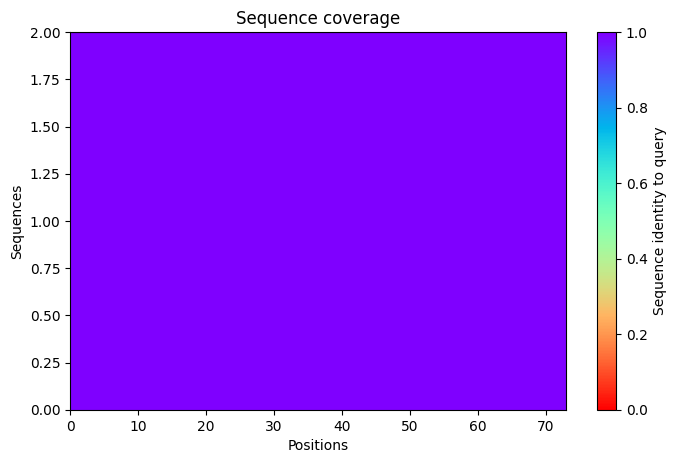

2023-02-13 10:34:27,205 Padding length to 73
2023-02-13 10:34:27,206 Setting max_seq=2, max_extra_seq=1
2023-02-13 10:35:01,497 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=81.3 pTM=0.597
2023-02-13 10:35:01,979 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=86.4 pTM=0.661
2023-02-13 10:35:02,484 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=86.7 pTM=0.662
2023-02-13 10:35:02,987 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=87 pTM=0.666
2023-02-13 10:35:02,992 alphafold2_ptm_model_1_seed_000 took 23.7s (3 recycles)


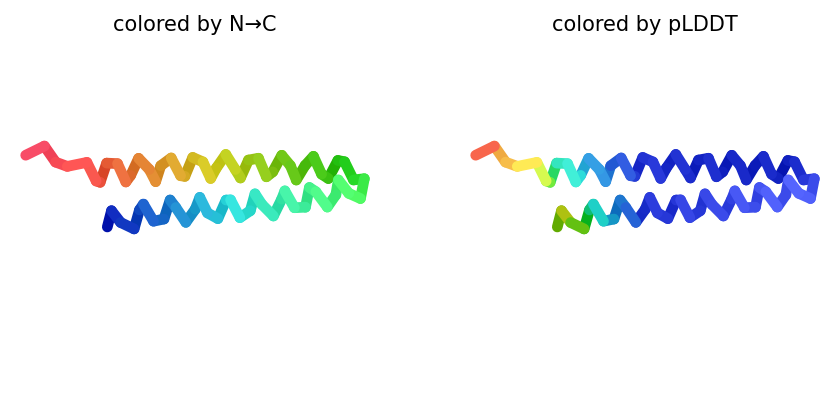

2023-02-13 10:35:05,755 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=69.3 pTM=0.358
2023-02-13 10:35:06,285 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=78.7 pTM=0.428
2023-02-13 10:35:06,799 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=80.7 pTM=0.44
2023-02-13 10:35:07,366 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=80.9 pTM=0.44
2023-02-13 10:35:07,371 alphafold2_ptm_model_2_seed_000 took 2.3s (3 recycles)


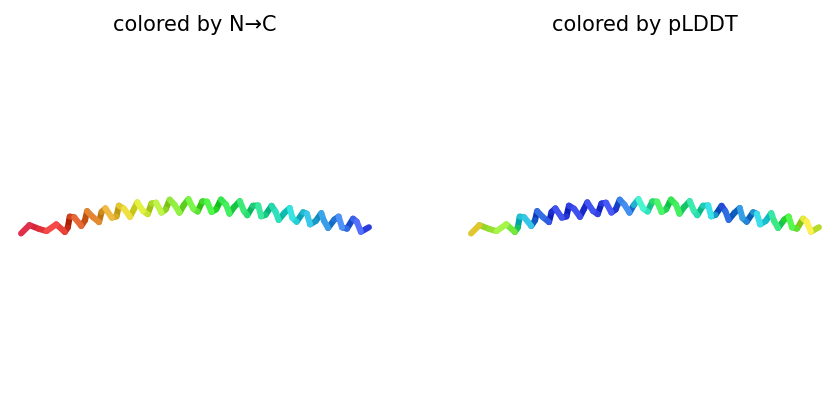

2023-02-13 10:35:09,654 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=69.9 pTM=0.318
2023-02-13 10:35:10,138 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=70.7 pTM=0.319
2023-02-13 10:35:10,621 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=74.6 pTM=0.349
2023-02-13 10:35:11,109 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=76.2 pTM=0.362
2023-02-13 10:35:11,113 alphafold2_ptm_model_3_seed_000 took 2.0s (3 recycles)


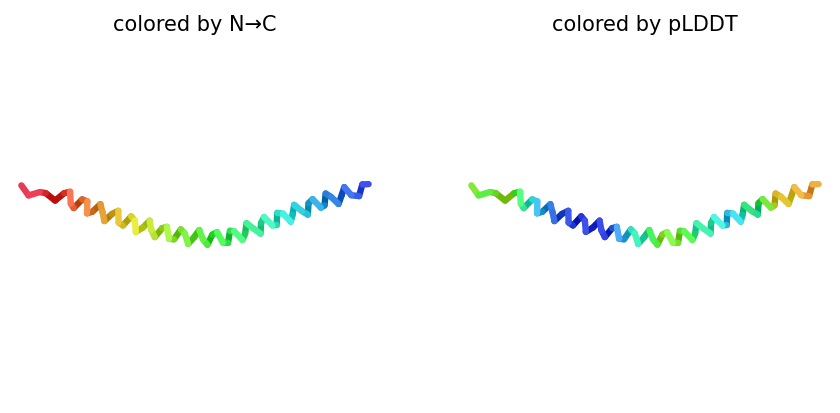

2023-02-13 10:35:13,015 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=80.1 pTM=0.535
2023-02-13 10:35:13,503 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=81.4 pTM=0.575
2023-02-13 10:35:13,992 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=82.3 pTM=0.598
2023-02-13 10:35:14,478 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=82.6 pTM=0.599
2023-02-13 10:35:14,482 alphafold2_ptm_model_4_seed_000 took 2.0s (3 recycles)


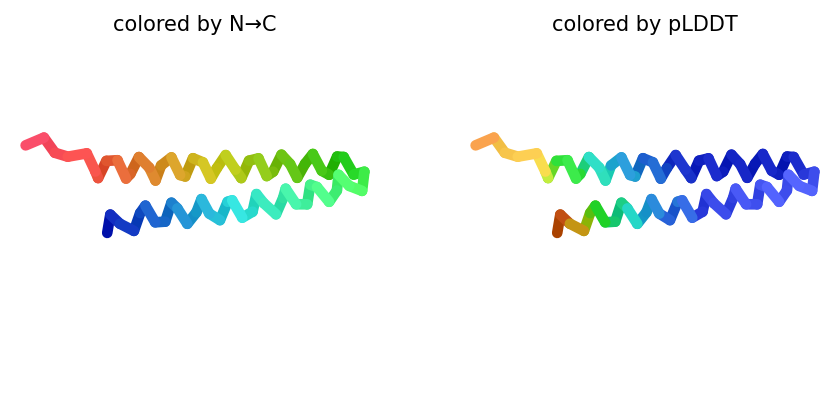

2023-02-13 10:35:16,348 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=70.3 pTM=0.311
2023-02-13 10:35:16,839 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=72.4 pTM=0.367
2023-02-13 10:35:17,326 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=75.7 pTM=0.376
2023-02-13 10:35:17,814 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=76.1 pTM=0.379
2023-02-13 10:35:17,818 alphafold2_ptm_model_5_seed_000 took 2.0s (3 recycles)


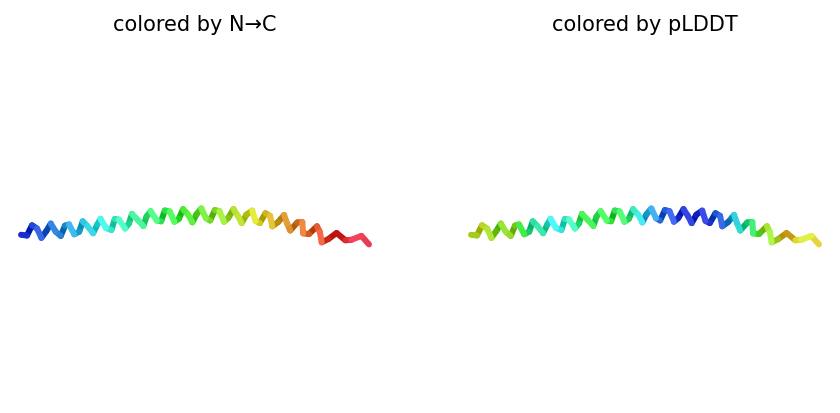

2023-02-13 10:35:18,045 reranking models by 'plddt' metric
2023-02-13 10:35:18,046 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=87 pTM=0.666
2023-02-13 10:35:18,047 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=82.6 pTM=0.599
2023-02-13 10:35:18,048 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=80.9 pTM=0.44
2023-02-13 10:35:18,049 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=76.2 pTM=0.362
2023-02-13 10:35:18,050 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=76.1 pTM=0.379
2023-02-13 10:35:21,049 Done


0

In [5]:
#@title Correr predicción
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):  
  if display_images:    
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
if 'logging_setup' not in globals():
    setup_logging(Path(os.path.join(jobname,"log.txt")))
    logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

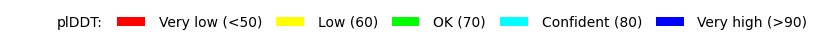

In [6]:
#@title Mostrar estructura en 3D {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show() 


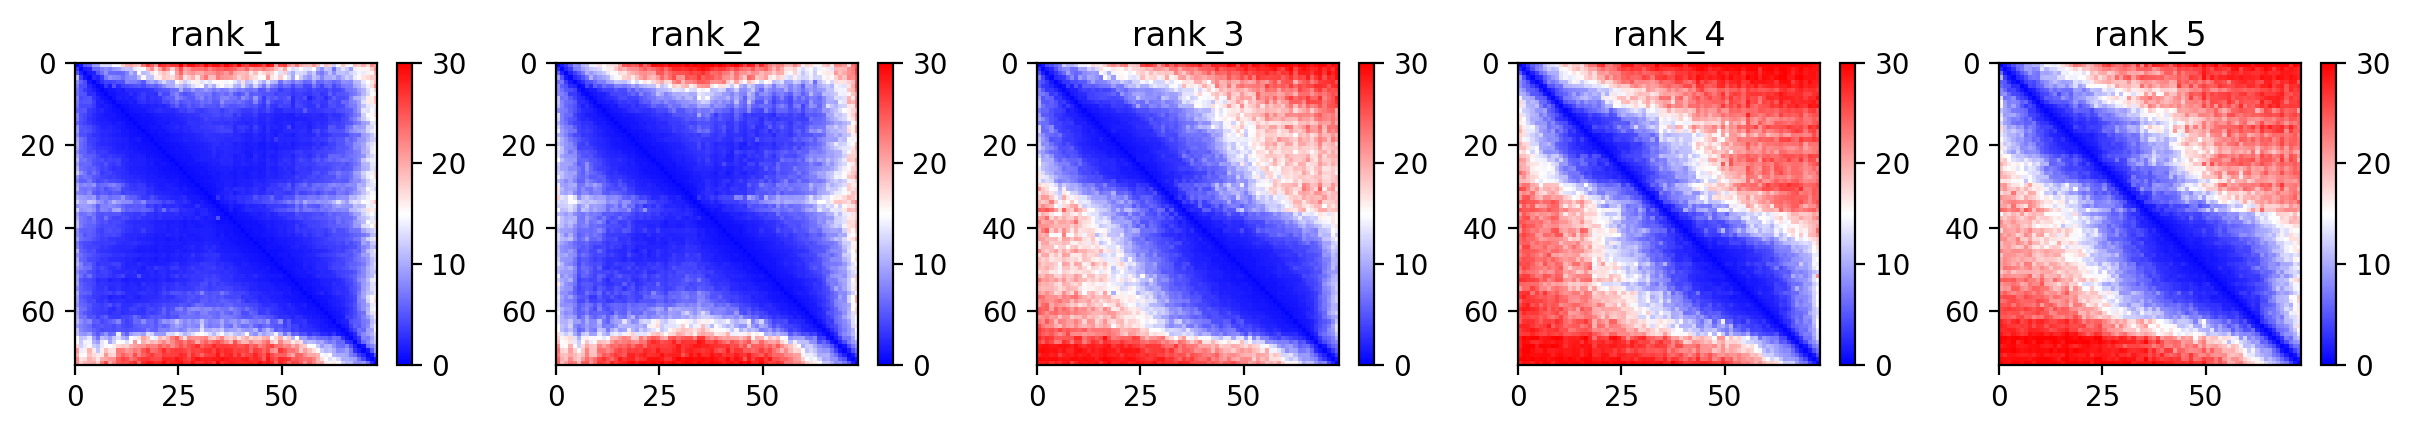
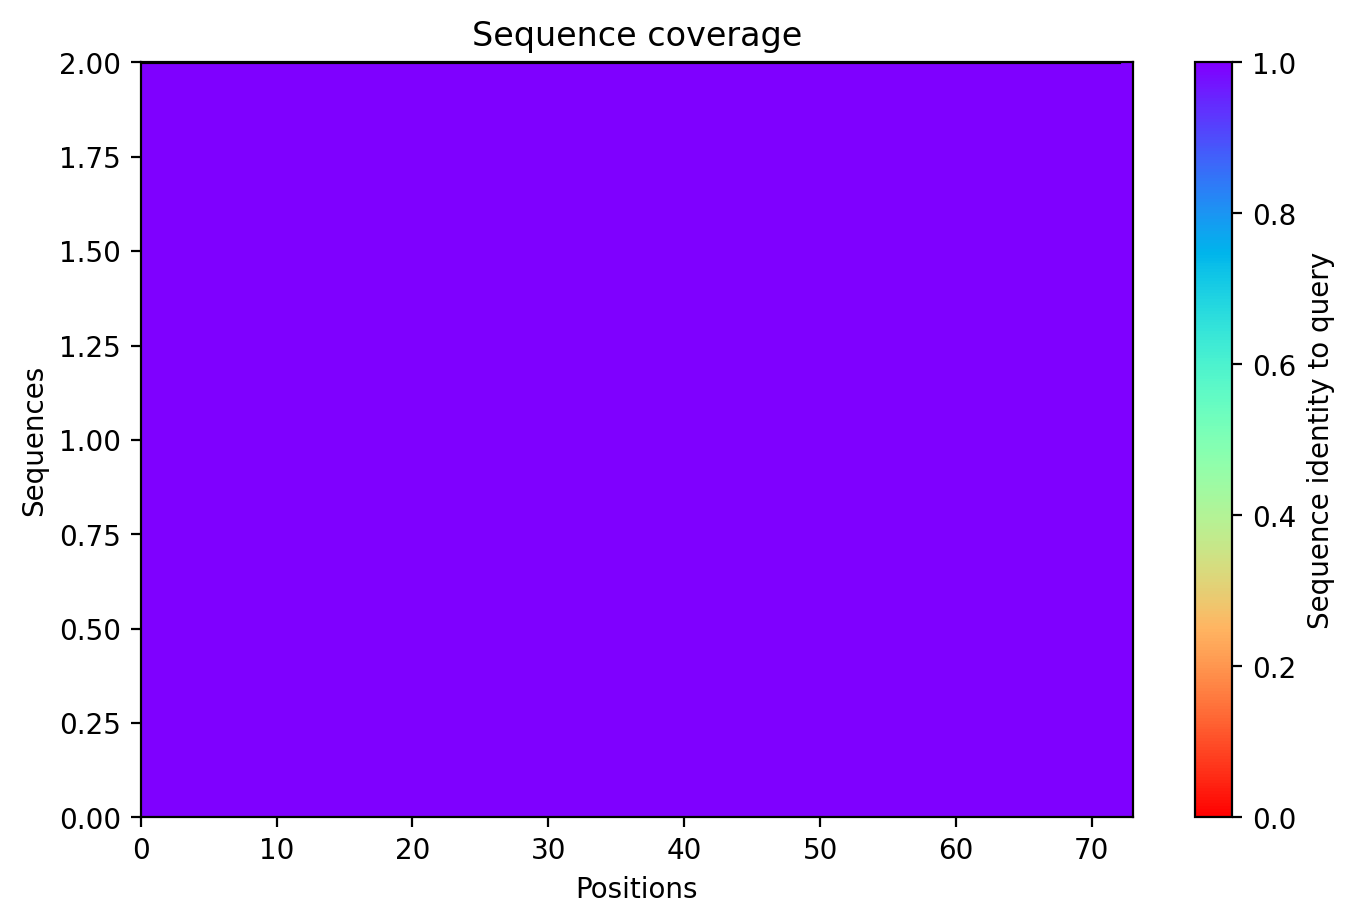
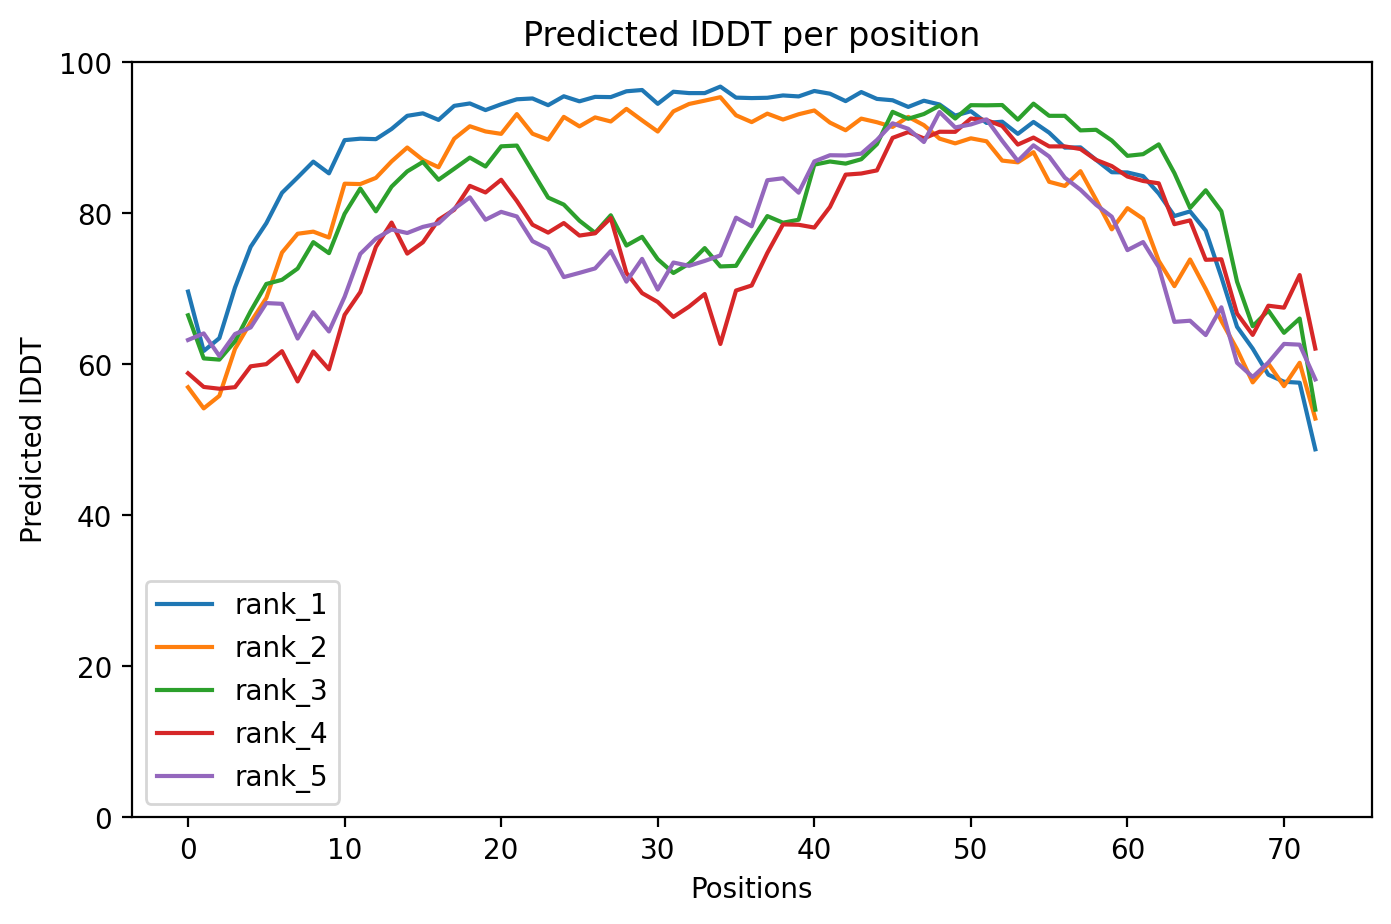

In [7]:
#@title Gráficos {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [8]:
#@title Resultados de paquetes y descargas
#@markdown Si tienes problemas para descargar el archivo de resultados, intenta desactivar tu adblocker y vuelve a ejecutar esta celda. Si eso falla, haga clic en el icono de la carpeta pequeña a la izquierda, navegue hasta el archivo: nombre_de_trabajo.resultado.zip, haga clic con el botón derecho y seleccione "Descargar" (ver [captura de pantalla](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instrucciones <a name="Instructions"></a>
**Inicio rápido**
1. Pegue su(s) secuencia(s) proteínica(s) en el campo de entrada.
2. Pulse "Tiempo de ejecución" -> "Ejecutar todo".
3. El pipeline consta de 5 pasos. El paso que se está ejecutando actualmente se indica mediante un círculo con una señal de stop al lado.

**Contenido del archivo zip**

1. Las estructuras formateadas en PDB están ordenadas por pLDDT medio y los complejos están ordenados por pTMscore. (no relajado y relajado si `use_amber` está activado).
2. Gráficos de la calidad del modelo.
3. Gráficos de la cobertura MSA.
4. Archivo de registro de parámetros.
5. MSA de entrada con formato A3M.
6. Un `predicted_aligned_error_v1.json` usando el formato [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) y un `scores.json` para cada modelo que contiene un array (lista de listas) para PAE, una lista con el pLDDT medio y el pTMscore.
7. Archivo BibTeX con citas de todas las herramientas y bases de datos utilizadas.

Al final del trabajo, aparecerá un cuadro modal de descarga con un archivo `jobname.result.zip`. Además, si se ha seleccionado la opción `save_to_google_drive`, el archivo `jobname.result.zip` se cargará en Google Drive.

**Solución de problemas**
* Compruebe que el tipo de runtime es GPU en "Runtime" -> "Change runtime type".
* Intente reiniciar la sesión en "Runtime" -> "Factory reset runtime".
* Comprueba la secuencia de entrada.

**Problemas conocidos**
* Google Colab asigna diferentes tipos de GPUs con diferentes cantidades de memoria. Algunas pueden no tener suficiente memoria para predecir la estructura de una secuencia larga.
* Su navegador puede bloquear la ventana emergente para descargar el archivo de resultados. Puedes elegir la opción `save_to_google_drive` para subirlo a Google Drive en su lugar o descargar manualmente el archivo de resultados: Haga clic en el icono de la carpeta pequeña a la izquierda, navegue hasta el archivo: nombre_de_trabajo.resultado.zip, haz clic con el botón derecho y selecciona "Descargar" (ver [captura de pantalla](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitaciones**
* Recursos informáticos: Nuestra API MMseqs2 puede manejar ~20-50k peticiones al día.
* MSAs: MMseqs2 es muy preciso y sensible pero puede encontrar menos resultados comparado con HHblits/HMMer buscado contra BFD o MGnify.
* Recomendamos utilizar adicionalmente el [AlphaFold2 pipeline] completo (https://github.com/deepmind/alphafold).

**Descripción de los gráficos**
* **Número de secuencias por posición** - Queremos ver al menos 30 secuencias por posición, para un mejor rendimiento, idealmente 100 secuencias.
* **LDDT prevista por posición** - confianza del modelo (sobre 100) en cada posición. Cuanto más alto, mejor.
* **Error de alineación previsto** - Para homooligómeros, esta podría ser una métrica útil para evaluar la confianza del modelo en la interfaz. Cuanto más bajo, mejor.

**Agradecimientos**
- A [Felipe Zuñiga]([https://www.linkedin.com/in/dfzunigah), Andres Peralta y Sergio Guzman por este tutorial.

- Agradecemos al equipo de AlphaFold el desarrollo de un modelo excelente y el software de código abierto. 

- KOBIC](https://kobic.re.kr) y [Söding Lab](https://www.mpinat.mpg.de/soeding) por proporcionar los recursos computacionales para el servidor MMseqs2 MSA.

- Richard Evans por su ayuda en la evaluación comparativa del soporte Alphafold-multimer de ColabFold.

- David Koes](https://github.com/dkoes) por su impresionante plugin [py3Dmol](https://3dmol.csb.pitt.edu/), ¡sin el cual estos cuadernos serían bastante aburridos!

- Do-Yoon Kim por crear el logo de ColabFold.

- Una colaboración de Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) y Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).

**Licencia**

El código fuente de ColabFold está licenciado bajo [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Además, este cuaderno utiliza el código fuente de AlphaFold2 y sus parámetros bajo licencia [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) y [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectivamente. Más información sobre la licencia de AlphaFold [aquí](https://github.com/deepmind/alphafold).

##ColabFold v1.5.1: AlphaFold2 using MMseqs2

Para más detalles, consulte <a href="#Instrucciones">inferior</a> del cuaderno, eche un vistazo a [ColabFold GitHub](https://github.com/sokrypton/ColabFold) y lea nuestro manuscrito. 

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1) 
